In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
import pymongo

In [3]:
connection = pymongo.MongoClient('localhost',27017)

db = connection.db
db_slowing = db.slowing

In [33]:
max_parameters = db_slowing.distinct(key = 'params',filter = {'target' : {'$gte' : 30}})

for i in max_parameters:
    print(i)

{'det_1': 96.22434561859045, 'det_2': 15.482231288112553, 'laseroff': 398845.9685114464, 'laseron': 162426.83781029694, 'main_det': 19.434382715500604, 'pr_1': 1.2983134215897505, 'pr_2': 5.531458066690437}
{'det_1': 96.2250089106507, 'det_2': 15.482894579701505, 'laseroff': 398853.87979081424, 'laseron': 162434.77182242164, 'main_det': 19.435046007089554, 'pr_1': 1.2989767132376138, 'pr_2': 5.5321213583383}
{'det_1': 131.14873947457312, 'det_2': 23.276787355666592, 'laseroff': 413183.70900542923, 'laseron': 151068.6804156147, 'main_det': 17.740785097512074, 'pr_1': 6.468883874031582, 'pr_2': 6.6513032661587195}
{'det_1': 134.44120693433575, 'det_2': 25.530124356630573, 'laseroff': 383327.42511146795, 'laseron': 168208.16382302827, 'main_det': 17.820350769753453, 'pr_1': 1.2691559983093021, 'pr_2': 5.463567643880943}
{'det_1': 137.01021160419424, 'det_2': 19.904466312664383, 'laseroff': 495173.74736586557, 'laseron': 193879.74414201418, 'main_det': 19.344629443126056, 'pr_1': 6.0436082

In [4]:
#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.0005/x0
dv = 0.05
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(0,3500000,1)

# The detunings used in the PRAs:
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*(0.012)**2)/Isat
power_index = 2

#Make the axis:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)



H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [6]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff,s,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    pow_rate1 = pr_1/(2+pr_1)
    pow_rate2 = pr_2/(4+pr_2)
    pow_rate1_i = (1-pow_rate1)/2
    pow_rate2_i = (1-pow_rate2)/4
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    
    laserBeams = pylcp.laserBeams()
# Minus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0     
        
    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])

    return laserBeams

In [34]:
def slow_bayesian(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
    magField = pylcp.quadrupoleMagneticField(mag_field_grad)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_longitudianl = np.linspace(14,21,8)
    v_trans = np.linspace(-0.5,0.5,7)
    sols = list()
    for v0_l in v_longitudinal:
        for v0_t in v_trans:
            rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_l/np.sqrt(2),v0_l/np.sqrt(2),v0_t]))
            rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

            rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,max_step=1e5,progress_bar = 0,method='LSODA')
            sols.append(rateeq.sol)
    return sols

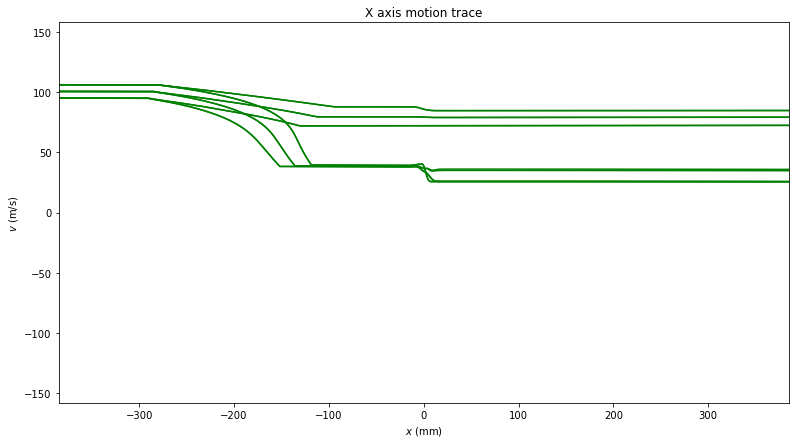

In [19]:
fig, ax = plt.subplots(1, 1,figsize=(13,7))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$x\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('X axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[0]*x0*1000,sol.v[0]*v0, 'g')
    
# fig.savefig('./MOT/Error.png')
# fig.savefig('./MOT/No Error.png')

In [15]:
def slow_bayesian(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
    magField=pylcp.quadrupoleMagneticField(mag_field_grad*x0)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_h = np.linspace(17,19,3)*np.sqrt(1/2)
    v_v = np.linspace(-0.5,0.5,4)
    counter = 0
    for v0_h in v_h:
        for v0_v in v_v:
            eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0_h,v0_h,v0_v]))
            eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
            eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 1,method='LSODA',max_step=1e5)
            sol = eqn.sol

            if abs(sol.r[0][-1])*1000*x0<5 and abs(sol.r[2][-1])*1000*x0<5 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[2][-1])<5e-2:
                print(abs(sol.r[0][-1])*1000*x0,abs(sol.r[2][-1])*1000*x0)
                counter+=1
            else:
                print(abs(sol.r[0][-1])*1000*x0,abs(sol.r[2][-1])*1000*x0)
                pass
    return counter

In [16]:
start = time.time()

print(slow_bayesian(17,120,10,1.2,1.5,138250,400015))

print(time.time()-start)

Completed in 13.91 s.                                                   
1496.567917722418 52.985874446673755
Completed in 15.74 s.                                                  
475.92966502170356 15.734370692204944
Completed in 15.39 s.                                                  
480.0140194135979 14.498901160813835
Completed in 12.05 s.                                                   
1497.5711830431292 53.198554731629436
Completed in 12.97 s.                                                   
1668.1974675598462 70.40036835249964
Completed in 17.23 s.                                                  
657.2242586823298 28.356756040610968
Completed in 17.51 s.                                                  
679.2322114388622 29.053137227238114
Completed in 13.06 s.                                                   
1675.3288936830231 62.471660331588296
Completed in 12.15 s.                                                   
1812.8560680933483 110.25799414603384
Completed 

In [43]:
pbounds = {'main_det':(10,20),'det_1':(70,170),'det_2':(5,30),'pr_1':(0.5,10),'pr_2':(0.5,10),'laseron':(138240,300000),'laseroff':(300001,600000)}

In [44]:
optimizer = BayesianOptimization(
    f = slow_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [45]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |   pr_1    |   pr_2    |
-------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_slowing.json',reset=False)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=5,
    n_iter=10,)
print(time.time()-start)